In [30]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
import numpy as np

In [2]:
# Load field polygons
fields_zh_gdf = gpd.read_file('../data/ZH_2019_LW_NUTZUNGSFLAECHEN_F.shp')
fields_tg_gdf = gpd.read_file('../data/TG_2019_Nutzungsflaechen_2019.gpkg')

In [5]:
def save_as_geojson(gdf, file_path):
    """
    Save a GeoPandas DataFrame as a GeoJSON file.

    Parameters:
    gdf (geopandas.GeoDataFrame): The GeoDataFrame to save.
    file_path (str): The path where the GeoJSON file will be saved.
    """
    # Ensure the output format is GeoJSON
    gdf.to_file(file_path, driver='GeoJSON')

In [6]:
save_as_geojson(fields_zh_gdf, '../data/fields_zh.geojson')
save_as_geojson(fields_tg_gdf, '../data/fields_tg.geojson')

In [10]:
# Load the area of interest (AOI) from the uploaded GeoJSON file
aoi = gpd.read_file("./data/aoi.geojson")

# Load GeoJSON files
zh_gdf = gpd.read_file("./data/fields_zh.geojson")

# project into the crs that fields_zh is
aoi = aoi.to_crs(fields_zh_gdf.crs)

In [12]:
# Perform spatial join to keep only polygons within the AOI
zh_filtered = gpd.sjoin(zh_gdf, aoi, predicate="intersects")

# Export the filtered GeoDataFrame to a GeoJSON file
zh_filtered.to_file("./data/fields_zh_filtered.geojson", driver="GeoJSON")

len(zh_filtered)

2609

In [14]:
zh_red = zh_filtered[["GEMEINDE", "FLAECHE", "NUTZUNG", "NUTZUNGSCO", "JAHR", "geometry"]]
zh_red

,GEMEINDE,FLAECHE,NUTZUNG,NUTZUNGSCO,JAHR,geometry
2,Bäretswil,46.0,Übrige Dauerwiesen (ohne Weiden),0613,2019,"POLYGON ((2704608.023 1244765.418, 2704602.857..."
17,Bäretswil,151.0,Übrige Dauerwiesen (ohne Weiden),0613,2019,"POLYGON ((2704648.891 1244748.591, 2704645.880..."
103,Russikon,5.0,Extensiv genutzte Wiesen (ohne Weiden),0611,2019,"POLYGON ((2701418.739 1249171.183, 2701418.360..."
134,Seegräben,7.0,Übrige Dauerwiesen (ohne Weiden),0613,2019,"POLYGON ((2699919.721 1244718.684, 2699935.574..."
301,Hittnau,492.0,Übrige Dauerwiesen (ohne Weiden),0613,2019,"POLYGON ((2703863.731 1247984.918, 2703846.810..."
...,...,...,...,...,...,...
102025,Hittnau,74.0,Übrige Dauerwiesen (ohne Weiden),0613,2019,"POLYGON ((2704505.210 1246166.364, 2704529.044..."
102027,Hittnau,74.0,Übrige Dauerwiesen (ohne Weiden),0613,2019,"POLYGON ((2704627.109 1245232.898, 2704595.361..."
102028,Hittnau,117.0,Kunstwiese (ohne Weiden),0601,2019,"POLYGON ((2704463.724 1247044.883, 2704462.891..."
102121,Pfäffikon,66.0,Übrige Dauerwiesen (ohne Weiden),0613,2019,"POLYGON ((2702818.704 1246673.264, 2702840.344..."


In [16]:
# Load stacked features metadata
stacked_features = rasterio.open('../data/stacked_features.tif')
transform = stacked_features.transform

In [ ]:
# Function to get 224x224 image chip for a given field
def get_image_chip(field_geom, size=224):
    # Get the bounding box of the field
    minx, miny, maxx, maxy = field_geom.bounds
    # Calculate the center of the bounding box
    centerx, centery = (minx + maxx) / 2, (miny + maxy) / 2
    # Calculate the pixel coordinates of the center
    pixelx, pixely = ~transform * (centerx, centery)
    # Calculate the pixel coordinates of the top-left corner of the chip
    startx, starty = int(pixelx - size / 2), int(pixely - size / 2)
    # Extract the chip for each band in the selected timestep
    chip = stacked_features.read(window=((starty, starty + size), (startx, startx + size)))
    return chip

In [34]:
# Reduce geotiff to aoi
import rasterio

# Open the stacked features GeoTIFF
with rasterio.open('../data/stacked_features.tif') as src:
    # Reproject AOI to the raster's CRS
    aoi = aoi.to_crs(src.crs)

    # Extract the geometry in the format required by rasterio
    geoms = [feature["geometry"] for feature in aoi.__geo_interface__["features"]]

    # Mask the raster with the AOI
    out_image, out_transform = mask(src, geoms, crop=True)

    # Copy the metadata and update to match the masked array
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
    })

    # Save the masked raster to a new file
    with rasterio.open("./data/stacked_features_reduced.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [37]:

# Define a multiplier for brightness adjustment (optional)
MULTIPLIER = 100.0  # Adjust this value as needed to control brightness

# Open the stacked features GeoTIFF
with rasterio.open('../data/stacked_features.tif') as src:
    # Reproject AOI to the raster's CRS
    aoi = aoi.to_crs(src.crs)

    # Extract the geometry in the format required by rasterio
    geoms = [feature["geometry"] for feature in aoi.__geo_interface__["features"]]

    # Mask the raster with the AOI
    out_image, out_transform = mask(src, geoms, crop=True)

    # Rescale each band to 8-bit
    out_image_8bit = np.zeros_like(out_image, dtype=np.uint8)
    for i in range(out_image.shape[0]):
        band = out_image[i, :, :] * MULTIPLIER  # Apply brightness multiplier
        band = np.clip(band, 0, 65535)  # Ensure values are within the 16-bit range
        band = (band / 255).astype(np.uint8)  # Convert to 8-bit
        out_image_8bit[i, :, :] = band

    # Copy the metadata and update to match the 8-bit array
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "dtype": 'uint8',  # Set data type to 8-bit
        "height": out_image_8bit.shape[1],
        "width": out_image_8bit.shape[2],
        "transform": out_transform,
        "count": out_image_8bit.shape[0]  # Number of bands
    })

    # Save the 8-bit masked raster to a new file
    with rasterio.open("./data/stacked_features_reduced_8bit.tif", "w", **out_meta) as dest:
        dest.write(out_image_8bit)

In [28]:
# show the bands of the reduced geotiff
with rasterio.open("./data/stacked_features_reduced.tif") as src:
    for i in range(1, src.count + 1):
        band = src.read(i)
        print(f"Band {i}: {band.min()} - {band.max()}")

Band 1: 0 - 14376
Band 2: 0 - 7440
Band 3: 0 - 7716
Band 4: 0 - 13688
Band 5: 0 - 7899
Band 6: 0 - 10485
Band 7: 0 - 6528
Band 8: 0 - 6068
Band 9: 0 - 5864
Band 10: 0 - 6668
Band 11: 0 - 7701
Band 12: 0 - 9766
Band 13: 0 - 10432
Band 14: 0 - 10280
Band 15: 0 - 10336
Band 16: 0 - 10216
Band 17: 0 - 7323
Band 18: 0 - 7455
Band 19: 0 - 11944
Band 20: 0 - 14656
Band 21: 0 - 16256
Band 22: 0 - 15409
Band 23: 0 - 5973
Band 24: 0 - 5962
Band 25: 0 - 16104
Band 26: 0 - 12112
Band 27: 0 - 7928
Band 28: 0 - 15408
Band 29: 0 - 15108
Band 30: 0 - 14164
Band 31: 0 - 16184
Band 32: 0 - 16752
Band 33: 0 - 17600
Band 34: 0 - 15496
Band 35: 0 - 12988
Band 36: 0 - 14898
Band 37: 0 - 5604
Band 38: 0 - 5260
Band 39: 0 - 4928
Band 40: 0 - 6676
Band 41: 0 - 7107
Band 42: 0 - 7704
Band 43: 0 - 9168
Band 44: 0 - 10584
Band 45: 0 - 11184
Band 46: 0 - 14112
Band 47: 0 - 12773
Band 48: 0 - 14271
Band 49: 0 - 8080
Band 50: 0 - 5128
Band 51: 0 - 5352
Band 52: 0 - 7420
Band 53: 0 - 4008
Band 54: 0 - 3878


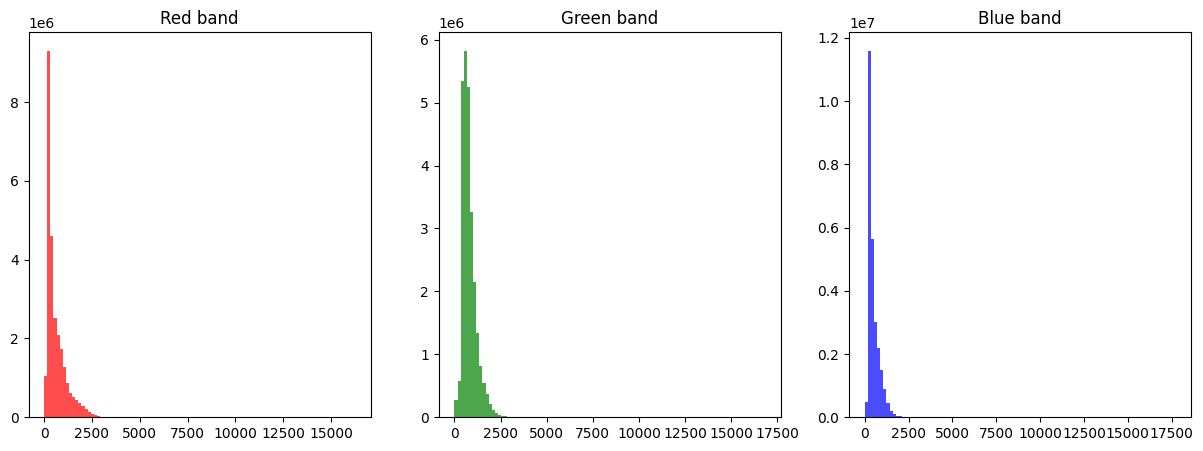

In [33]:
# make histograms of band 31, 32, 33 from stacked_features
import matplotlib.pyplot as plt

# Open the stacked features GeoTIFF
with rasterio.open('../data/stacked_features.tif') as src:
    # Read the bands
    red = src.read(31)
    green = src.read(32)
    blue = src.read(33)

    # Plot histograms
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].hist(red.flatten(), bins=100, color='red', alpha=0.7, histtype='stepfilled')
    axs[0].set_title("Red band")
    axs[1].hist(green.flatten(), bins=100, color='green', alpha=0.7, histtype='stepfilled')
    axs[1].set_title("Green band")
    axs[2].hist(blue.flatten(), bins=100, color='blue', alpha=0.7, histtype='stepfilled')
    axs[2].set_title("Blue band")
    plt.show()

We look for optimal min and max values in displaying the rasterized Sentinel-2 Data using 2nd and 98th percentiles, similar to how QGIS does it.

In [42]:
import rasterio
import numpy as np

# Dictionary to store min, max, 2nd and 98th percentiles for each band
band_stats = {
    "R": {"min": None, "max": None, "2nd_percentile": None, "98th_percentile": None},
    "G": {"min": None, "max": None, "2nd_percentile": None, "98th_percentile": None},
    "B": {"min": None, "max": None, "2nd_percentile": None, "98th_percentile": None},
    "NIR": {"min": None, "max": None, "2nd_percentile": None, "98th_percentile": None},
    "SWIR1": {"min": None, "max": None, "2nd_percentile": None, "98th_percentile": None},
    "SWIR2": {"min": None, "max": None, "2nd_percentile": None, "98th_percentile": None},
}

# List of band names corresponding to the stacked features
band_names = ["R", "G", "B", "NIR", "SWIR1", "SWIR2"]

with rasterio.open('../data/stacked_features.tif') as src:
    for i, band_name in enumerate(band_names):
        # Initialize list to store all pixel values for the current band across all timesteps
        all_band_values = []

        for timestep in range(9):  # Loop through 9 timesteps
            # Calculate the correct band index in the stacked GeoTIFF
            band_index = i + timestep * 6 + 1  # rasterio bands are 1-indexed
            
            # Read the data for the current band
            band_data = src.read(band_index)

            # Flatten the band data and add it to the list
            all_band_values.extend(band_data.flatten())

        # Convert to a numpy array for easier calculations
        all_band_values = np.array(all_band_values)

        # Calculate min, max, 2nd (2nd percentile), and 98th (98th percentile) percentiles
        band_min = np.min(all_band_values)
        band_max = np.max(all_band_values)
        second_percentile = np.percentile(all_band_values, 2)
        ninety_eighth_percentile = np.percentile(all_band_values, 98)

        # Store the calculated values in the dictionary
        band_stats[band_name]["min"] = band_min
        band_stats[band_name]["max"] = band_max
        band_stats[band_name]["2nd_percentile"] = second_percentile
        band_stats[band_name]["98th_percentile"] = ninety_eighth_percentile

# Print the resulting dictionary with min, max, 2nd and 98th percentile values
print(band_stats)

{'R': {'min': 0, 'max': 18528, '2nd_percentile': 95.0, '98th_percentile': 1878.0}, 'G': {'min': 0, 'max': 19808, '2nd_percentile': 175.0, '98th_percentile': 1570.0}, 'B': {'min': 0, 'max': 21424, '2nd_percentile': 89.0, '98th_percentile': 1206.0}, 'NIR': {'min': 0, 'max': 17089, '2nd_percentile': 165.0, '98th_percentile': 5468.0}, 'SWIR1': {'min': 0, 'max': 15479, '2nd_percentile': 120.0, '98th_percentile': 3361.0}, 'SWIR2': {'min': 0, 'max': 15325, '2nd_percentile': 94.0, '98th_percentile': 2709.0}}


In [43]:
band_stats

{'R': {'min': 0,
  'max': 18528,
  '2nd_percentile': 95.0,
  '98th_percentile': 1878.0},
 'G': {'min': 0,
  'max': 19808,
  '2nd_percentile': 175.0,
  '98th_percentile': 1570.0},
 'B': {'min': 0,
  'max': 21424,
  '2nd_percentile': 89.0,
  '98th_percentile': 1206.0},
 'NIR': {'min': 0,
  'max': 17089,
  '2nd_percentile': 165.0,
  '98th_percentile': 5468.0},
 'SWIR1': {'min': 0,
  'max': 15479,
  '2nd_percentile': 120.0,
  '98th_percentile': 3361.0},
 'SWIR2': {'min': 0,
  'max': 15325,
  '2nd_percentile': 94.0,
  '98th_percentile': 2709.0}}

## Model Inference Code

In [25]:
import rasterio
from rasterio.windows import Window
from rasterio.transform import rowcol
from torchvision import transforms

from transformers import PretrainedConfig
from messis.messis import Messis  # Assuming you have a custom model class

import numpy as np

import torch
import yaml
import os

In [26]:
config = PretrainedConfig.from_pretrained('crop-classification/messis', revision='47d9ca4')
model = Messis.from_pretrained('crop-classification/messis', cache_dir='./hf_cache/', revision='47d9ca4')

/Users/yvokeller/Library/Caches/pypoetry/virtualenvs/messis-bV8Bs8aq-py3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TemporalViTEncoder | Using HuggingFace pretrained weights.


In [27]:
from app.inference import InferenceDataLoader

# Example usage:
features_path = "../data/stacked_features.tif"
labels_path = "../data/labels.tif"
field_ids_path = "../data/field_ids.tif"
stats_path = "../data/chips_stats.yaml"

loader = InferenceDataLoader(features_path, labels_path, field_ids_path, stats_path, n_timesteps=9, fold_indices=[0], debug=True)

# Get data for a specific latitude and longitude
satellite_data, label_data, field_ids_data, features_transform, features_crs = loader.get_data(8.635254,47.381789) # Coordinates must be in EPSG:4326 - are converted to the CRS of the raster

# Print the shape of the extracted data
print(satellite_data.shape)
print(label_data.shape)
print(field_ids_data.shape)

Loading mean/std stats from ../data/chips_stats.yaml
Stats with selected test fold 0: {'mean': [570.7305297851562, 691.6322021484375, 436.3498229980469, 3222.44775390625, 1939.10009765625, 1180.9752197265625], 'n_chips': 72, 'std': [466.30303955078125, 355.8695373535156, 305.64422607421875, 1125.038330078125, 681.1266479492188, 632.9395751953125]} over 9 timesteps.
Row: 2060, Column: 3537
Extracted window data from ../data/stacked_features.tif
Min: 1, Max: 17888
Extracted window data from ../data/labels.tif
Min: 0, Max: 36
Extracted window data from ../data/field_ids.tif
Min: 0, Max: 102029
torch.Size([1, 6, 9, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


In [28]:
# load labels.tif
with rasterio.open('../data/stacked_features.tif') as src:
    labels = src.read()
    labels_meta = src.meta

    print(labels.shape)
    print(labels_meta)

# load labels.tif
with rasterio.open('../data/labels.tif') as src:
    labels = src.read()
    labels_meta = src.meta

    print(labels.shape)
    print(labels_meta)
    
with rasterio.open('../data/field_ids.tif') as src:
    labels = src.read()
    labels_meta = src.meta

    print(labels.shape)
    print(labels_meta)


(54, 5120, 5120)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 5120, 'height': 5120, 'count': 54, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 451864.75251478516,
       0.0, -10.0, 5283035.423337242)}
(1, 5120, 5120)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5120, 'height': 5120, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 451864.75251478516,
       0.0, -10.0, 5283035.423337242)}
(1, 5120, 5120)
{'driver': 'GTiff', 'dtype': 'uint32', 'nodata': None, 'width': 5120, 'height': 5120, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 451864.75251478516,
       0.0, -10.0, 5283035.423337242)}


In [29]:
# load dataset_info.json
import json

with open('../data/dataset_info.json', 'r') as file:
    dataset_info = json.load(file)

tiers_dict = {k: v for k, v in config.hparams.get('heads_spec').items() if v.get('is_metrics_tier', False)}
tiers = list(tiers_dict.keys())

print(tiers)

['tier1', 'tier2', 'tier3']


In [30]:
# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output = model(satellite_data)['tier3_refinement_head']

output.shape

torch.Size([1, 49, 224, 224])

In [31]:
from messis.messis import LogConfusionMatrix

# Print input shapes
print(output.shape)
print(label_data.shape)
print(field_ids_data.shape)

pixelwise_outputs_stacked, majority_outputs_stacked = LogConfusionMatrix.get_pixelwise_and_majority_outputs(output, tiers, field_ids=field_ids_data, dataset_info=dataset_info)

majority_tier3_predictions = majority_outputs_stacked[2]

# unique values in majority_tier3_predictions
unique, counts = np.unique(majority_outputs_stacked[2], return_counts=True)
print(dict(zip(unique, counts)))

torch.Size([1, 49, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
{0: 18985, 1: 16456, 2: 5852, 3: 2844, 4: 139, 5: 3137, 6: 758, 7: 789, 8: 19, 9: 22, 11: 865, 15: 54, 16: 17, 18: 24, 24: 199, 34: 16}


In [46]:
field_ids_data.shape

torch.Size([1, 224, 224])

In [61]:
import torch
import numpy as np
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

def tensor_to_polygons_with_fields(field_ids, targets, predictions, transform, crs, class_names):
    """
    Convert field_ids, targets, and predictions tensors to polygons with corresponding class references.
    
    :param field_ids: PyTorch tensor of shape (1, 224, 224) representing individual fields
    :param targets: PyTorch tensor of shape (1, 224, 224) for targets
    :param predictions: PyTorch tensor of shape (1, 224, 224) for predictions
    :param transform: Affine transform for georeferencing
    :param crs: Coordinate reference system (CRS) of the data
    :param class_names: Dictionary mapping class indices to class names
    :return: GeoPandas DataFrame with polygons, prediction class labels, and target class labels
    """
    # Step 1: Convert the tensors to NumPy arrays
    field_array = field_ids.squeeze().cpu().numpy().astype(np.int32)  # Unique IDs for fields
    target_array = targets.squeeze().cpu().numpy().astype(np.int8)
    pred_array = predictions.squeeze().cpu().numpy().astype(np.int8)

    # Step 2: Generate polygons based on field_ids
    polygons = []
    field_values = []
    target_values = []
    pred_values = []

    for geom, field_value in shapes(field_array, transform=transform):
        polygons.append(shape(geom))
        field_values.append(field_value)

        # Get a single value from the field area for targets and predictions
        target_value = target_array[field_array == field_value][0]
        pred_value = pred_array[field_array == field_value][0]
        
        target_values.append(target_value)
        pred_values.append(pred_value)

    # Step 3: Create a GeoPandas DataFrame
    gdf = gpd.GeoDataFrame({
        'geometry': polygons,
        'field_id': field_values,
        'target': target_values,
        'prediction': pred_values
    }, crs=crs)

    # Step 4: Apply class names to the prediction and target columns
    gdf['prediction_class'] = gdf['prediction'].apply(lambda x: class_names[x])
    gdf['target_class'] = gdf['target'].apply(lambda x: class_names[x])

    # Step 5: Add a column to indicate whether the prediction was correct
    gdf['correct'] = gdf['target'] == gdf['prediction']

    # Make correct astype int
    gdf['correct'] = gdf['correct']

    return gdf

# Example usage:
# Assuming `majority_tier3_predictions` is the PyTorch tensor of shape [1, 224, 224]
gdf = tensor_to_polygons_with_fields(field_ids_data, majority_tier3_predictions, label_data, features_transform, features_crs, class_names=dataset_info['tier3'])

# Filter out small polygons
gdf = gdf[gdf.geometry.area > 250]

# Save geodatafrme
gdf.to_file("./data/predictions.geojson", driver="GeoJSON")

# Now you have a GeoPandas DataFrame with polygons and class labels
gdf.head()

,geometry,field_id,target,prediction,prediction_class,target_class,correct
2,"POLYGON ((486684.753 5263555.423, 486684.753 5...",12228.0,1,1,Meadow,Meadow,True
3,"POLYGON ((487004.753 5263555.423, 487004.753 5...",0.0,0,0,Background,Background,True
6,"POLYGON ((487954.753 5263555.423, 487954.753 5...",18078.0,1,1,Meadow,Meadow,True
9,"POLYGON ((486114.753 5263555.423, 486114.753 5...",9742.0,1,1,Meadow,Meadow,True
10,"POLYGON ((486174.753 5263555.423, 486174.753 5...",9770.0,1,4,Pasture,Meadow,False


In [57]:
gdf

,geometry,field_id,target,prediction,prediction_class,target_class,correct
0,"POLYGON ((486284.753 5263555.423, 486284.753 5...",38635.0,1,1,Meadow,Meadow,True
1,"POLYGON ((486414.753 5263555.423, 486414.753 5...",0.0,0,0,Background,Background,True
2,"POLYGON ((486684.753 5263555.423, 486684.753 5...",12228.0,1,1,Meadow,Meadow,True
3,"POLYGON ((487004.753 5263555.423, 487004.753 5...",0.0,0,0,Background,Background,True
4,"POLYGON ((487084.753 5263555.423, 487084.753 5...",0.0,0,0,Background,Background,True
...,...,...,...,...,...,...,...
1511,"POLYGON ((487884.753 5261325.423, 487884.753 5...",0.0,0,0,Background,Background,True
1512,"POLYGON ((487904.753 5261325.423, 487904.753 5...",85462.0,1,1,Meadow,Meadow,True
1513,"POLYGON ((488104.753 5261345.423, 488104.753 5...",60500.0,16,3,Maize,Apples,False
1514,"POLYGON ((488274.753 5261335.423, 488274.753 5...",57438.0,2,3,Maize,WinterWheat,False


In [60]:
gdf_filtered = gdf[gdf.geometry.area > 250]

gdf_filtered

,geometry,field_id,target,prediction,prediction_class,target_class,correct
2,"POLYGON ((486684.753 5263555.423, 486684.753 5...",12228.0,1,1,Meadow,Meadow,True
3,"POLYGON ((487004.753 5263555.423, 487004.753 5...",0.0,0,0,Background,Background,True
6,"POLYGON ((487954.753 5263555.423, 487954.753 5...",18078.0,1,1,Meadow,Meadow,True
9,"POLYGON ((486114.753 5263555.423, 486114.753 5...",9742.0,1,1,Meadow,Meadow,True
10,"POLYGON ((486174.753 5263555.423, 486174.753 5...",9770.0,1,4,Pasture,Meadow,False
...,...,...,...,...,...,...,...
1504,"POLYGON ((487614.753 5261415.423, 487614.753 5...",0.0,0,0,Background,Background,True
1505,"POLYGON ((487544.753 5261375.423, 487544.753 5...",39518.0,1,1,Meadow,Meadow,True
1506,"POLYGON ((487534.753 5261355.423, 487534.753 5...",0.0,0,0,Background,Background,True
1513,"POLYGON ((488104.753 5261345.423, 488104.753 5...",60500.0,16,3,Maize,Apples,False


In [51]:
gdf

,geometry,field_id,target,prediction,prediction_class,target_class,correct
0,"POLYGON ((486284.753 5263555.423, 486284.753 5...",38635.0,1,1,Meadow,Meadow,True
1,"POLYGON ((486414.753 5263555.423, 486414.753 5...",0.0,0,0,Background,Background,True
2,"POLYGON ((486684.753 5263555.423, 486684.753 5...",12228.0,1,1,Meadow,Meadow,True
3,"POLYGON ((487004.753 5263555.423, 487004.753 5...",0.0,0,0,Background,Background,True
4,"POLYGON ((487084.753 5263555.423, 487084.753 5...",0.0,0,0,Background,Background,True
...,...,...,...,...,...,...,...
1511,"POLYGON ((487884.753 5261325.423, 487884.753 5...",0.0,0,0,Background,Background,True
1512,"POLYGON ((487904.753 5261325.423, 487904.753 5...",85462.0,1,1,Meadow,Meadow,True
1513,"POLYGON ((488104.753 5261345.423, 488104.753 5...",60500.0,16,3,Maize,Apples,False
1514,"POLYGON ((488274.753 5261335.423, 488274.753 5...",57438.0,2,3,Maize,WinterWheat,False


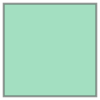

In [33]:
gdf.iloc[250].geometry

In [34]:
import numpy as np
import torch
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.affinity import affine_transform
from scipy.ndimage import find_objects

def create_geopandas_df(field_ids, majority_outputs, dataset_info, crs=None, transform=None):    
    # Convert tensors to numpy arrays
    field_ids_np = field_ids.cpu().numpy()
    majority_outputs_np = majority_outputs.cpu().numpy()

    # Get unique field IDs
    unique_field_ids = np.unique(field_ids_np)
    
    # Create lists to store results
    polygons = []
    class_indices = []
    class_names = []

    # Iterate over each unique field ID
    for field_id in unique_field_ids:
        # Find the mask for the current field_id
        mask = field_ids_np == field_id

        # Find the bounding box of the current field_id
        slices = find_objects(mask.astype(int))[0]
        
        # Get the coordinates of the bounding box
        coords = np.argwhere(mask)

        # Create the polygon from the coordinates (bounding box)
        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        polygon = Polygon([
            (min_col, min_row),
            (min_col, max_row),
            (max_col, max_row),
            (max_col, min_row)
        ])
        
        # Apply the affine transformation if provided
        if transform:
            # Convert the Affine object to the format required by shapely's affine_transform
            affine_params = [transform.a, transform.b, transform.d, transform.e, transform.xoff, transform.yoff]
            polygon = affine_transform(polygon, affine_params)
        
        # Get the most common class index for this field
        class_idx = np.bincount(majority_outputs_np[mask]).argmax()

        # Lookup the class name using the dataset_info
        class_name = dataset_info['tier3'][class_idx]

        # Store the polygon, class index, and class name
        polygons.append(polygon)
        class_indices.append(class_idx)
        class_names.append(class_name)

    # Create a GeoPandas DataFrame
    gdf = gpd.GeoDataFrame({
        'geometry': polygons,
        'class_index': class_indices,
        'class_name': class_names
    }, crs=crs)

    return gdf

In [35]:
# Use the CRS from your stacked_features GeoTIFF
import rasterio
with rasterio.open("../data/stacked_features.tif") as src:
    crs = src.crs
    transform = src.transform

majority_outputs_tier3 = majority_outputs_stacked[2][0]
field_ids = field_ids_data[0]

print(field_ids.shape)

print(majority_outputs_tier3.shape)
print(field_ids.shape)

gdf = create_geopandas_df(field_ids, majority_outputs_tier3, dataset_info, crs=crs, transform=transform)

torch.Size([224, 224])
torch.Size([224, 224])
torch.Size([224, 224])


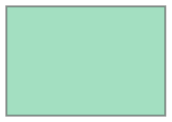

In [36]:
gdf.geometry[15]